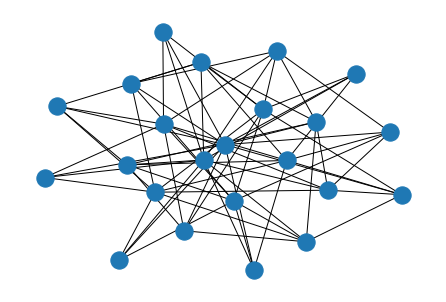

In [1]:
# Create a graph and visualize it
import networkx as nx
G = nx.mycielski_graph(5)

import matplotlib.pyplot as plt
nx.draw(G)

In [2]:
initial_colors = nx.greedy_color(G,strategy='smallest_last')
print("initial_colors =",initial_colors)

initial_colors = {5: 0, 1: 1, 0: 0, 12: 1, 7: 0, 14: 1, 4: 2, 3: 1, 2: 0, 9: 2, 21: 1, 22: 0, 15: 2, 13: 3, 6: 2, 8: 3, 11: 4, 10: 1, 20: 2, 19: 3, 18: 3, 17: 2, 16: 2}


In [3]:
colors_used = { initial_colors[i] for i in G.nodes }
print("colors_used =",colors_used)

colors_used = {0, 1, 2, 3, 4}


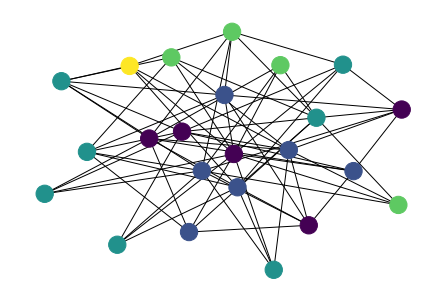

In [4]:
node_colors = [ initial_colors[i] for i in G.nodes ]
nx.draw( G, node_color=node_colors )

In [5]:
import gurobipy as gp
from gurobipy import GRB

In [6]:
def maximum_weight_independent_set( G, weight=None, forced_nodes=list() ):

    if weight is None:
        weight = { i : 1 for i in G.nodes }
        
    m = gp.Model()
    m.Params.OutputFlag = 0
    
    # x[i]=1 if pick vertex i
    x = m.addVars( G.nodes, vtype=GRB.BINARY )
    
    # can pick at most one endpoint of each edge {i,j}
    m.addConstrs( x[i] + x[j] <= 1 for i,j in G.edges )
    
    # each node in forced_nodes must be selected in our independent set
    for i in forced_nodes:
        x[i].LB = 1
        
    # maximize weight of independent set
    m.setObjective( gp.quicksum( weight[i] * x[i] for i in G.nodes ), GRB.MAXIMIZE )
    m.optimize()
    
    assert m.solCount > 0
    independent_set = [ i for i in G.nodes if x[i].x > 0.5 ]
    
    return (independent_set, m.objVal)

In [7]:
(ind_set, size) = maximum_weight_independent_set(G)
print("Here is a maximum (cardinality) independent set =",ind_set)
print("Its size is =",size)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-01
Here is a maximum (cardinality) independent set = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
Its size is = 11.0


In [8]:
def fractional_chromatic_number( G ):
    
    # Get an initial coloring, somehow
    initial_colors = nx.greedy_color(G,strategy='smallest_last')
    colors_used = { initial_colors[i] for i in G.nodes }
    ind_sets = [ [ i for i in G.nodes if initial_colors[i] == color ] for color in colors_used ]
    
    print("Intializing model with these independent sets (or columns):")
    num_ind_sets = len(ind_sets)
    for j in range(num_ind_sets):
        ind_set = ind_sets[j]
        print(j,':',ind_set)
    print("")
    
    m = gp.Model()
    m.Params.OutputFlag = 0
    
    # Idea: x[j]=1 if we use the j-th independent set
    #       However, we are solving the LP relaxation ("fractional chromatic number")
    #       So, we let x[j] be continuous!
    x = m.addVars( num_ind_sets, vtype=GRB.CONTINUOUS )
    
    # Cover constraints (cc): each vertex should be covered *at least* once
    cc = m.addConstrs( gp.quicksum( x[j] for j in range(num_ind_sets) if i in ind_sets[j] ) >= 1 for i in G.nodes )
    
    # Objective: minimize the number of ind sets used
    m.setObjective( gp.quicksum(x), GRB.MINIMIZE )
    
    print("Applying column generation algorithm")
    print("iter \t obj \t mwis \t reduced_cost")
    epsilon = 0.00001
    max_iterations = 1000
    
    for iteration in range(max_iterations):

        # Solve the set cover linear program
        m.optimize()

        # Get values of dual variables
        dual_vals = { i : cc[i].Pi for i in G.nodes }
        #print(dual_vals)

        # Find a maximum weight independent set, where vertex i has weight dual_vals[i]
        (mwis, mwis_weight) = maximum_weight_independent_set(G, weight=dual_vals)

        reduced_cost = 1 - mwis_weight
        print(iteration,'\t','{0:.2f}'.format(m.objVal),'\t','{0:.2f}'.format(mwis_weight),'\t','{0:.2f}'.format(reduced_cost))

        # Exit if all reduced costs are positive
        if reduced_cost > -epsilon:
            break
        
        # ... a trick to make our independent set (inclusion-wise) maximal
        (mwis, ignore_this_weight) = maximum_weight_independent_set(G, forced_nodes=mwis)

        # Add a variable to our problem for our new (maximal) independent set
        #   whose coefficient in the objective function is 1
        x[num_ind_sets] = m.addVar(obj=1)
        
        # Add this variable to relevant constraints
        for i in mwis:
            m.chgCoeff( cc[i], x[num_ind_sets], 1)
            
        ind_sets.append(mwis)
        num_ind_sets += 1
      
    soln = { j : x[j].x for j in range(num_ind_sets) }
    
    print("\nFractional chromatic number =",'{0:.4f}'.format(m.objVal),"using:")
    for j in range(len(ind_sets)):
        ind_set = ind_sets[j]
        if soln[j] > epsilon:
            print('x[',j,"] =",'{0:.4f}'.format(soln[j]),"which is",ind_set)
    
    return (ind_sets, soln, m.objVal)

In [9]:
(ind_sets, soln, obj) = fractional_chromatic_number(G)

Intializing model with these independent sets (or columns):
0 : [0, 2, 5, 7, 22]
1 : [1, 3, 10, 12, 14, 21]
2 : [4, 6, 9, 15, 16, 17, 20]
3 : [8, 13, 18, 19]
4 : [11]

Applying column generation algorithm
iter 	 obj 	 mwis 	 reduced_cost
0 	 5.00 	 3.00 	 -2.00
1 	 5.00 	 3.00 	 -2.00
2 	 5.00 	 3.00 	 -2.00
3 	 5.00 	 3.00 	 -2.00
4 	 4.50 	 2.50 	 -1.50
5 	 4.33 	 2.33 	 -1.33
6 	 4.00 	 2.50 	 -1.50
7 	 4.00 	 3.00 	 -2.00
8 	 3.67 	 1.67 	 -0.67
9 	 3.59 	 1.82 	 -0.82
10 	 3.50 	 1.75 	 -0.75
11 	 3.45 	 1.55 	 -0.55
12 	 3.41 	 1.44 	 -0.44
13 	 3.33 	 1.67 	 -0.67
14 	 3.33 	 1.48 	 -0.48
15 	 3.33 	 1.40 	 -0.40
16 	 3.33 	 1.17 	 -0.17
17 	 3.33 	 1.31 	 -0.31
18 	 3.33 	 1.33 	 -0.33
19 	 3.30 	 1.23 	 -0.23
20 	 3.29 	 1.12 	 -0.12
21 	 3.29 	 1.22 	 -0.22
22 	 3.29 	 1.21 	 -0.21
23 	 3.27 	 1.15 	 -0.15
24 	 3.26 	 1.07 	 -0.07
25 	 3.26 	 1.08 	 -0.08
26 	 3.25 	 1.08 	 -0.08
27 	 3.25 	 1.05 	 -0.05
28 	 3.24 	 1.00 	 -0.00

Fractional chromatic number = 3.2448 using:
x[